### **Trabajo Práctico 1. Aplicaciones Computacionales en Negocios**

#### **Preguntas exploratorias**

**¿Cuántos aviones aterrizan en AEP entre las 6am y la medianoche?**

Partimos de la información de que en promedio arriban **350 vuelos por día** al Aeroparque Jorge Newbery (AEP).  

Como un día completo tiene 24 horas, eso equivale a aproximadamente:

350 / 24 ≈ 14,6 vuelos por hora

Entre las 6 am y la medianoche transcurren 18 horas, por lo que estimamos:

14,6 * 18 ≈ 263 vuelos

*Respuesta final:* Alrededor de **263 aviones** aterrizan en AEP en ese rango horario.

**¿Cuánto es una milla náutica en kilómetros? ¿Y un nudo en kilómetros por hora?**

Las equivalencias son:

- 1 milla náutica (mn) = 1,852 km
- 1 nudo (k) = 1,852 km/h

**A partir de la data anterior, ¿cuánto tardaría un avión en llegar desde las 100 mn hasta AEP? Y si la velocidad a más de 100 mn fuera 500 nudos, ¿cuánto tardaría en llegar desde Rosario a AEP? Estos órdenes de magnitud, ¿tienen sentido con lo que se puede consultar en Aerolíneas Argentinas?**

##### Aproximación desde 100 mn a AEP
   - Distancia: 100 mn = 185,2 km 

   Tomando la tabla de distancia a AEP tenemos:
   1. 100 mn a 50 mn = 50 mn
      - 50 * 1,852 = 92,6 km
   2. 50 mn a 15 mn = 35 mn
      - 35 * 1,852 = 64,82 km
   3. 15 mn a 5 mn = 10 mn
      - 10 * 1,852 = 18,52 km
   4. 5 mn a 0 mn (aterrizar) = 5 mn
      - 5 * 1,852 = 9,26 km

   Calculando la velocidad promedio en cada rango tenemos:
   1. (300 + 250) / 2 = 275 nudos
      - 275 * 1,852 = 509,3 km/h
   2. (250 + 200) / 2 = 225 nudos
      - 225 * 1,852 = 416,7 km/h
   3. (200 + 150) / 2 = 175 nudos
      - 175 * 1,852 = 324,1 km/h
   4. (150 + 120) / 2 = 135 nudos
      - 135 * 1,852 = 250,02 km/h

   Entonces, juntando distancia y velocidad tenemos:
   1. t1 = 92,6 km / 509,3 km/h = 0,18 h
      - 0,18 * 60 = 10,90 minutos
   2. t2 = 64,82 km / 416,7 km/h = 0,15 h
      - 0,15 * 60 = 9,33 minutos
   3. t3 = 18,52 km / 324,1 km/h = 0,057 h
      - 0,057 * 60 = 3,43 minutos
   4. t4 = 9,26 km / 250,02 km/h = 0,037 h
      - 0,037 * 60 = 2,2 minutos

   Sumando los t de cada tramo tenemos:
   Tiempo = t1 + t2 + t3 + t4 = 10,90 m + 9,33 m + 3,43 m + 2,2 m ≈ 26 minutos

##### Trayecto Rosario – AEP
   - Distancia aproximada: ≈ 293,6 km 
   - Velocidad: 500 nudos = 500 * 1,852 ≈ 926 km/h  
   - Tiempo = 293,6 / 926 ≈ 0,32 h * 60 ≈ 19 minutos

*Respuesta final:* El tiempo estimado es de **26 minutos** para la aproximación desde 100 mn y de **19 minutos** para el trayecto Rosario – AEP a 500 nudos. Estos órdenes de magnitud son consistentes con los tiempos de vuelo publicados por Aerolíneas Argentinas para recorridos cortos.  

**¿Cuál es la cantidad máxima de aterrizajes que podrían suceder en teoría en AEP por entre las 6am y la medianoche?**

En ese rango horario hay 18 horas, que equivalen a 1080 minutos.

Y sabiendo que no puede haber aterrizajes separados por menos de 4 minutos entre sí, tenemos:
1080 / 4 = **270 aterrizajes máximo**

#### **Parte 1 - Simulación de Monte Carlo**

In [18]:
from analisis import MetricasSimulacion
from graficos import (animar_con_estelas)
from simulacion import simular_con_historia

# Ejecutar simulación

datos_mc = simular_con_historia(
    lambda_por_min = 0.25,
    minutos = 200,
    seed = 42,
    dia_ventoso = False,
    metricas = MetricasSimulacion()
)

print(f"Aviones finales registrados en la historia: {len(datos_mc['historia'])}")

Aviones finales registrados en la historia: 58


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animar_fila_radar(historia, minutos, tail):
    """
    Animación estilo radar futurista:
    - Fila única de aviones acercándose a AEP.
    - Fondo oscuro con degradado.
    - Aviones luminosos (triángulos azules).
    - Estelas con efecto glow.
    """
    # Construyo por tiempo: lista de (id, distancia) en cada minuto
    por_tiempo = [[] for _ in range(minutos)]
    for _id, h in historia.items():
        for tt, xx in zip(h["t"], h["x"]):
            if 0 <= tt < minutos:
                por_tiempo[tt].append((_id, xx))
    
    # Estilo visual base
    plt.style.use("dark_background")
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.set_xlim(100, 0)   # de 100 mn a 0 mn
    ax.set_ylim(-1, 1)    # fila única
    ax.set_facecolor("black")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("✈️ Aproximación a AEP — Simulación Monte Carlo", 
                 color="#66ccff", fontsize=16, pad=15, weight="bold")
    
    estelas = {}  # id -> lista de (t, x) recientes
    
    # Aviones
    heads = ax.scatter([], [], s=160, marker=">", 
                       color="#00c3ff", edgecolor="white", lw=0.8, alpha=0.95)
    txt = ax.text(0.02, 0.85, "", transform=ax.transAxes, 
                  color="#66ccff", fontsize=12, alpha=0.9, family="monospace")
    
    def init():
        heads.set_offsets(np.empty((0, 2)))
        txt.set_text("")
        return heads, txt
    
    def update(t):
        # actualizar estelas
        for (_id, x) in por_tiempo[t]:
            if _id not in estelas:
                estelas[_id] = []
            estelas[_id].append((t, x))
            if len(estelas[_id]) > tail:
                estelas[_id] = estelas[_id][-tail:]
        
        # borrar líneas viejas
        for ln in list(ax.lines):
            ln.remove()
        
        # dibujar estelas glow
        xs_head, ys_head = [], []
        for eid, pts in estelas.items():
            xs = [x for (_, x) in pts]
            ys = [0] * len(xs)
            
            # glow: segmentos más brillantes cerca de la cabeza
            for i in range(1, len(xs)):
                alpha = i / len(xs)
                ax.plot(xs[i-1:i+1], ys[i-1:i+1], 
                        color=(0.1, 0.7, 1, alpha*0.5), lw=3, solid_capstyle="round")
            
            xs_head.append(xs[-1])
            ys_head.append(0)
        
        # actualizar cabezas
        if xs_head:
            heads.set_offsets(np.column_stack([xs_head, ys_head]))
        else:
            heads.set_offsets(np.empty((0, 2)))
        
        # texto
        txt.set_text(f"⏱ Minuto: {t:3d}\n✈️ Aviones activos: {len(xs_head)}")
        return heads, txt
    
    anim = FuncAnimation(fig, update, frames=minutos, init_func=init,
                         interval=120, blit=False)
    plt.close(fig)  # evitar duplicados en Jupyter
    return anim

In [ ]:
anim = animar_fila_radar(datos_mc["historia"], 200, 30)
HTML(anim.to_jshtml())   # interactivo

C:\Users\casa\AppData\Local\Temp\ipykernel_18388\2430583275.py:2: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans Mono.
  HTML(anim.to_jshtml())   # interactivo
C:\Users\casa\AppData\Local\Temp\ipykernel_18388\2430583275.py:2: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  HTML(anim.to_jshtml())   # interactivo


#### **Parte 2 - Promedio de arribos**

El modelo genera, en cada minuto, un avión con probabilidad λ. Para que el promedio de arrivos sea de un avión por hora debemos hacer:
$$ λ = 1 \text{ avión/hora} = \frac{1}{60} \text{ aviones/minuto} ≈ 0,0167 \text{ aviones/minuto} $$

#### **Parte 3 - Cinco aviones en una hora**

In [26]:
from main import estimar_prob_5

# Ejecutar la estimación Monte Carlo con la función ya implementada
p_hat, se, ic = estimar_prob_5(n_sim=200_000, seed=42)

print(f"Probabilidad estimada (Monte Carlo): {p_hat:.5f}")
print(f"Error estándar: {se:.5f}")
print(f"IC 95%: ({ic[0]:.5f}, {ic[1]:.5f})")

Probabilidad estimada (Monte Carlo): 0.00286
Error estándar: 0.00012
IC 95%: (0.00263, 0.00309)


Con la función `estimar_prob_5` se simuló un gran número de horas (200.000 repeticiones) con λ = 1/60 aviones por minuto.  
El resultado fue:
- Probabilidad estimada (Monte Carlo): 0.00286  
- Error estándar: 0.00012  
- IC 95%: (0.00263, 0.00309)

De manera analítica, el número de arribos en 1 hora sigue una distribución Poisson(μ=1).  
La probabilidad de que lleguen exactamente 5 aviones es:

$$ P(N=5) = \frac{e^{-1}\cdot 1^5}{5!} \approx 0.00307 $$

**Respuesta final:** La probabilidad de que lleguen 5 aviones en una hora es **aproximadamente 0,3%**, valor que coincide con la estimación obtenida por Monte Carlo (cae en el intervalo de confianza).

#### **Sistemas de Arribos con distintos λ**

In [4]:
lambdas = [0.02, 0.1, 0.2, 0.5, 1]
metricas_lambdas = {lam: MetricasSimulacion() for lam in lambdas}

=== EJERCICIO 4: Congestión y atrasos con distintos lambdas SIN dia ventoso ===
{'aterrizajes': 1077, 'aviones': 1101, 'en_vuelo': 24, 'reinserciones': 150, 'desvios_montevideo': 0, 'desvios_viento': 0, 'desvios_tormenta': 0}
{'aterrizajes': 5172, 'aviones': 5439, 'en_vuelo': 139, 'reinserciones': 4546, 'desvios_montevideo': 128, 'desvios_viento': 0, 'desvios_tormenta': 0}
{'aterrizajes': 6483, 'aviones': 10846, 'en_vuelo': 332, 'reinserciones': 17762, 'desvios_montevideo': 4031, 'desvios_viento': 0, 'desvios_tormenta': 0}
{'aterrizajes': 6371, 'aviones': 27091, 'en_vuelo': 436, 'reinserciones': 26663, 'desvios_montevideo': 20284, 'desvios_viento': 0, 'desvios_tormenta': 0}
{'aterrizajes': 5900, 'aviones': 54000, 'en_vuelo': 450, 'reinserciones': 12000, 'desvios_montevideo': 47650, 'desvios_viento': 0, 'desvios_tormenta': 0}


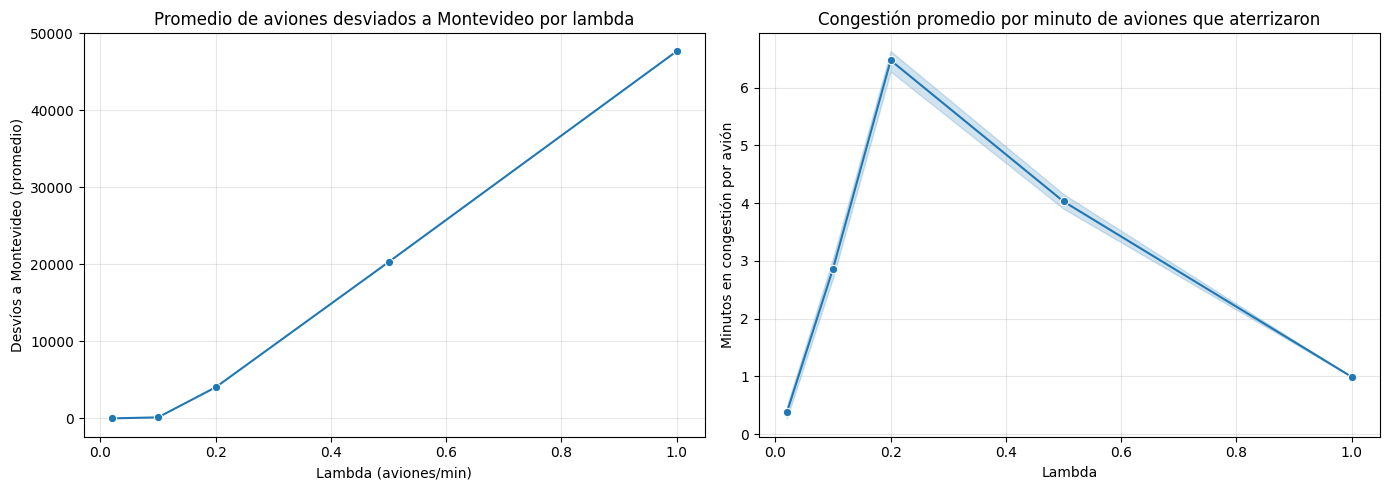

   lambda      mean       std  count  Error MonteCarlo  IC95_lower  IC95_upper
0    0.02  0.378798  0.415838     50          0.058808    0.263533    0.494062
1    0.10  2.864929  0.643841     50          0.091053    2.686465    3.043392
2    0.20  6.473134  0.624166     50          0.088270    6.300124    6.646144
3    0.50  4.029362  0.468069     50          0.066195    3.899620    4.159104
4    1.00  0.991525  0.000000     50          0.000000    0.991525    0.991525


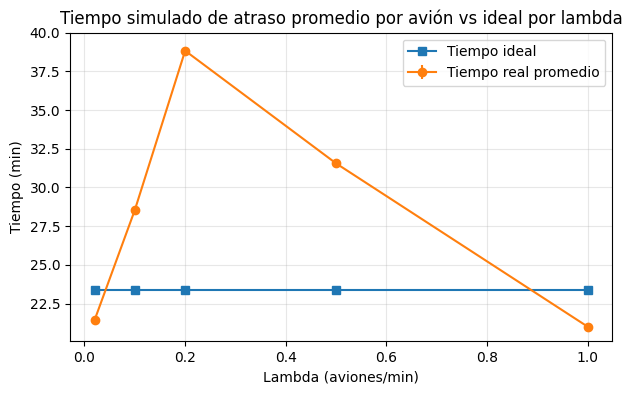

=== FIN EJERCICIO 4 ===



In [ ]:
# --------------------------------------------------------
# PARTE 4: SIMULACIÓN CON DISTINTOS λ (SIN DÍA VENTOSO)
# --------------------------------------------------------

print("=== EJERCICIO 4: Congestión y atrasos con distintos lambdas ===")

# HAY QUE CAMBIAR N_REP A 2000, PERO PARA PROBAR TARDA MUCHO
df = correr_experimentos(lambdas, n_rep = 50, dia_ventoso = False, metricas_lambda = metricas_lambdas, seed = 2025)
print_resumen(metricas_lambdas)

#GRÁFICOS DE CONGESTIÓN Y CANTIDAD DE AVIONES A MONTEVIDEO POR LAMBDA
plot_desvios_y_congestion(metricas_lambdas,df)
print(IC_globales(df))

#ATRASO CON Y SIN CONGESTIÓN
plot_comparacion_tiempos(df)

print("=== FIN EJERCICIO 4 ===\n") 


#### **Simulaciones con Viento**

In [ ]:
# --------------------------------------------------------
# PARTE 5: SIMULACIÓN CON DISTINTOS λ (CON DÍA VENTOSO)
# --------------------------------------------------------

print("=== EJERCICIO 5: Atrasos y desvíos con distintos λ CON día ventoso ===")

metricas_lambdas_ventoso = {lam: MetricasSimulacion() for lam in lambdas}

# HAY QUE CAMBIAR N_REP A 2000, PERO PARA PROBAR TARDA MUCHO
df_ventoso = correr_experimentos(lambdas, n_rep = 50, dia_ventoso = True, metricas_lambda = metricas_lambdas_ventoso)

for m in metricas_lambdas_ventoso:
    print(metricas_lambdas_ventoso[m].resumen())

plot_comparacion_tiempos(df_ventoso)

print("=== FIN EJERCICIO 5 ===\n")

#### **Simulaciones con tormenta**

In [ ]:
# --------------------------------------------------------
# PARTE 6: SIMULACIÓN CON TORMENTA (CIERRE SORPRESIVO AEP)
# --------------------------------------------------------

print("=== EJERCICIO 6: Solo tormenta de 30 minutos ===")

metricas_lambdas_tormenta = {lam: MetricasSimulacion() for lam in lambdas}

# HAY QUE CAMBIAR N_REP A 2000, PERO PARA PROBAR TARDA MUCHO
df_tormenta = correr_experimentos(lambdas, n_rep = 50, dia_ventoso = False, metricas_lambda = metricas_lambdas_tormenta, hay_tormenta = True)

for m in metricas_lambdas_tormenta:
    print(metricas_lambdas_tormenta[m].resumen())

plot_comparacion_tiempos(df_tormenta)

print("=== FIN EJERCICIO 6 ===\n")

#### **Posibles mejoras**

**COMPLETAR**

#### **BONUS**

**COMPLETAR**